# Importing necessary libraries

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model, initialpower
import bayesflow as bf

import seaborn as sns
import time
import pickle
import tensorflow as tf


from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

print('Using CAMB %s installed at %s' % (camb.__version__, os.path.dirname(camb.__file__)))
# to make sure the version and path is what you expect

INFO:bayesflow:Using backend 'tensorflow'


Using CAMB 1.6.1 installed at c:\Users\sabar\OneDrive\Documents\GitHub\Estimating-Cosmological-Parameters-from-Galaxy-Power-Spectrum\.venv\Lib\site-packages\camb


# Data Generating

In [7]:
def gen_logPK(H0, Omega_m, n_s, K_values=None, noise_level=0.2, seed=None):
    """
    Generate noisy matter power spectrum P(k) from given cosmological parameters.

    Parameters:
        H0 (float): Hubble constant (km/s/Mpc)
        Omega_m (float): total matter density (Ω_m)
        n_s (float): spectral index
        K_values (np.array or None): k values (1/Mpc). Default: logspace from 1e-3 to ~3.16
        noise_level (float): relative Gaussian noise (e.g., 0.05 = 5%)

    Returns:
        noisy_P_k (np.array): noisy matter power spectrum at redshift z=0
    """
    # Default k range: safe values for CAMB
    if K_values is None:
        K_values = np.logspace(-3.3, 0.7, 1000) # 1000 points from 1e-3 to 5e-1 (1/Mpc)

    ## To calculate the physical densities from the densities 
    # Baryon density
    Omega_b = 0.05
    
    # Cold dark matter density
    Omega_c = Omega_m - Omega_b

    # dimensionless Hubble parameter
    h = H0 / 100

    
    # physical densities
    ombh2 = Omega_b * h**2
    omch2 = Omega_c * h**2


    # Setup CAMB
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(ns=n_s)
    pars.set_matter_power(redshifts=[0], kmax=max(K_values))

    # Run CAMB and get P(k)
    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, kmax=max(K_values))
    P_k = PK.P(0, K_values)

     # Conditional RNG
    if seed is not None:
        rng = np.random.default_rng(seed)  # reproducible
    else:
        rng = np.random.default_rng()      # fresh random

    # Add heteroscedastic Gaussian noise.
    # Noise is added according to the scale of P_k which make more realistic observations
    # noise = rng.normal(0, noise_level * P_k)
    # P_k_noisy = P_k + noise

    # Step 2: Apply log10 to each output
    log_k = np.log10(K_values)
    #log_P_k_noisy = np.log10(P_k_noisy)
    
    
    
    
    log_Pk_clean = np.log10(P_k)

    log_noise = rng.normal(0, noise_level, len(P_k))
    log_P_k_noisy = log_Pk_clean + log_noise
    
    # shape adjustments
    log_k = log_k.reshape(-1, 1)
    log_Pk_clean = log_Pk_clean.reshape(-1, 1)
    log_P_k_noisy = log_P_k_noisy.reshape(-1, 1)

    return {     
        'log_k': log_k,
        'log_P_k_noisy': log_P_k_noisy,
        'log_Pk_clean': log_Pk_clean  
    }

# Noicy Data Generating

In [8]:
# Define the true cosmological parameters
parameters = {
    'H0': 67.4,
    'Omega_m': 0.315,
    'n_s': 0.965
}

In [9]:
# Generate the noisy power spectrum using parameters
pk_observations = gen_logPK(
    H0=parameters['H0'],
    Omega_m=parameters['Omega_m'],
    n_s=parameters['n_s'],
    noise_level=0.2,   # 20% relative Gaussian noise
    seed=42            # Optional, for reproducibility
)

# Visualization


P(k) vs k_vals

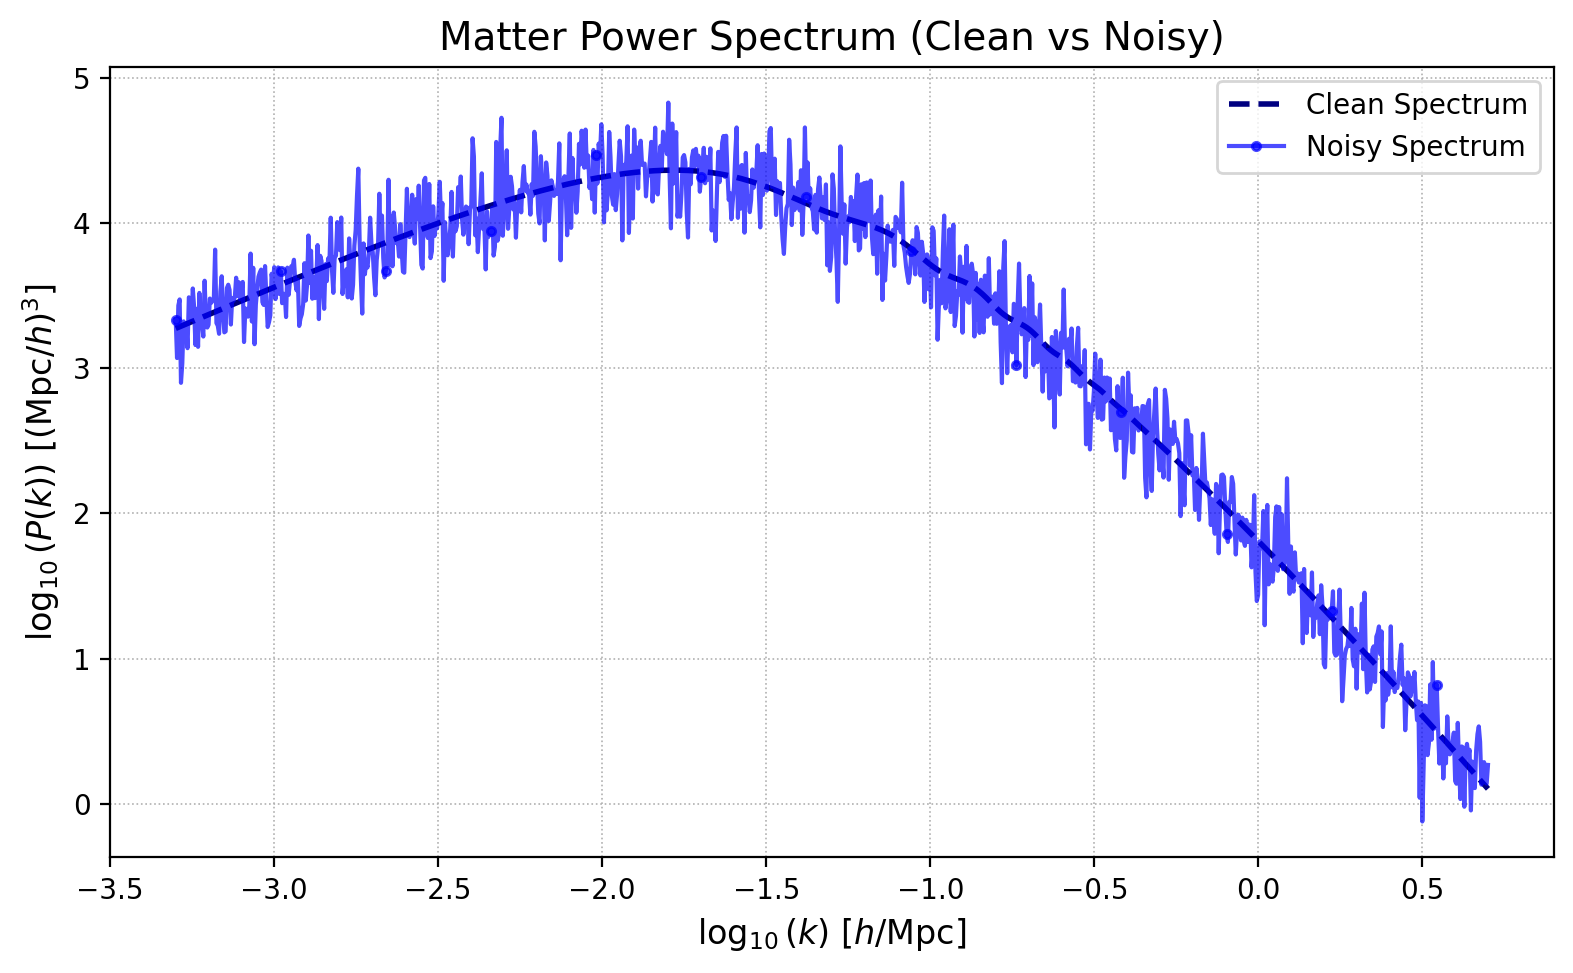

In [10]:

# Set figure size and style
plt.figure(figsize=(8, 5))

# Plot clean spectrum
plt.plot(
    pk_observations['log_k'],
    pk_observations['log_Pk_clean'],
    label='Clean Spectrum',
    color='navy',
    linewidth=2.0,
    linestyle='--'
)

# Plot noisy spectrum
plt.plot(
    pk_observations['log_k'],
    pk_observations['log_P_k_noisy'],
    label='Noisy Spectrum',
    color='blue',
    linewidth=1.5,
    linestyle='-',
    alpha=0.7,
    marker='o',
    markersize=3,
    markevery=80  # plot markers every ~80 points
)

# Axes labels and title
plt.xlabel(r'$\log_{10}(k)\ [h/\mathrm{Mpc}]$', fontsize=12)
plt.ylabel(r'$\log_{10}(P(k))\ [(\mathrm{Mpc}/h)^3]$', fontsize=12)

# Formatting
plt.title('Matter Power Spectrum (Clean vs Noisy)', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle=':', linewidth=0.6)
plt.tight_layout()

# Show the plot
plt.show()


$f(P\_k))$ is the probability density of power spectrum

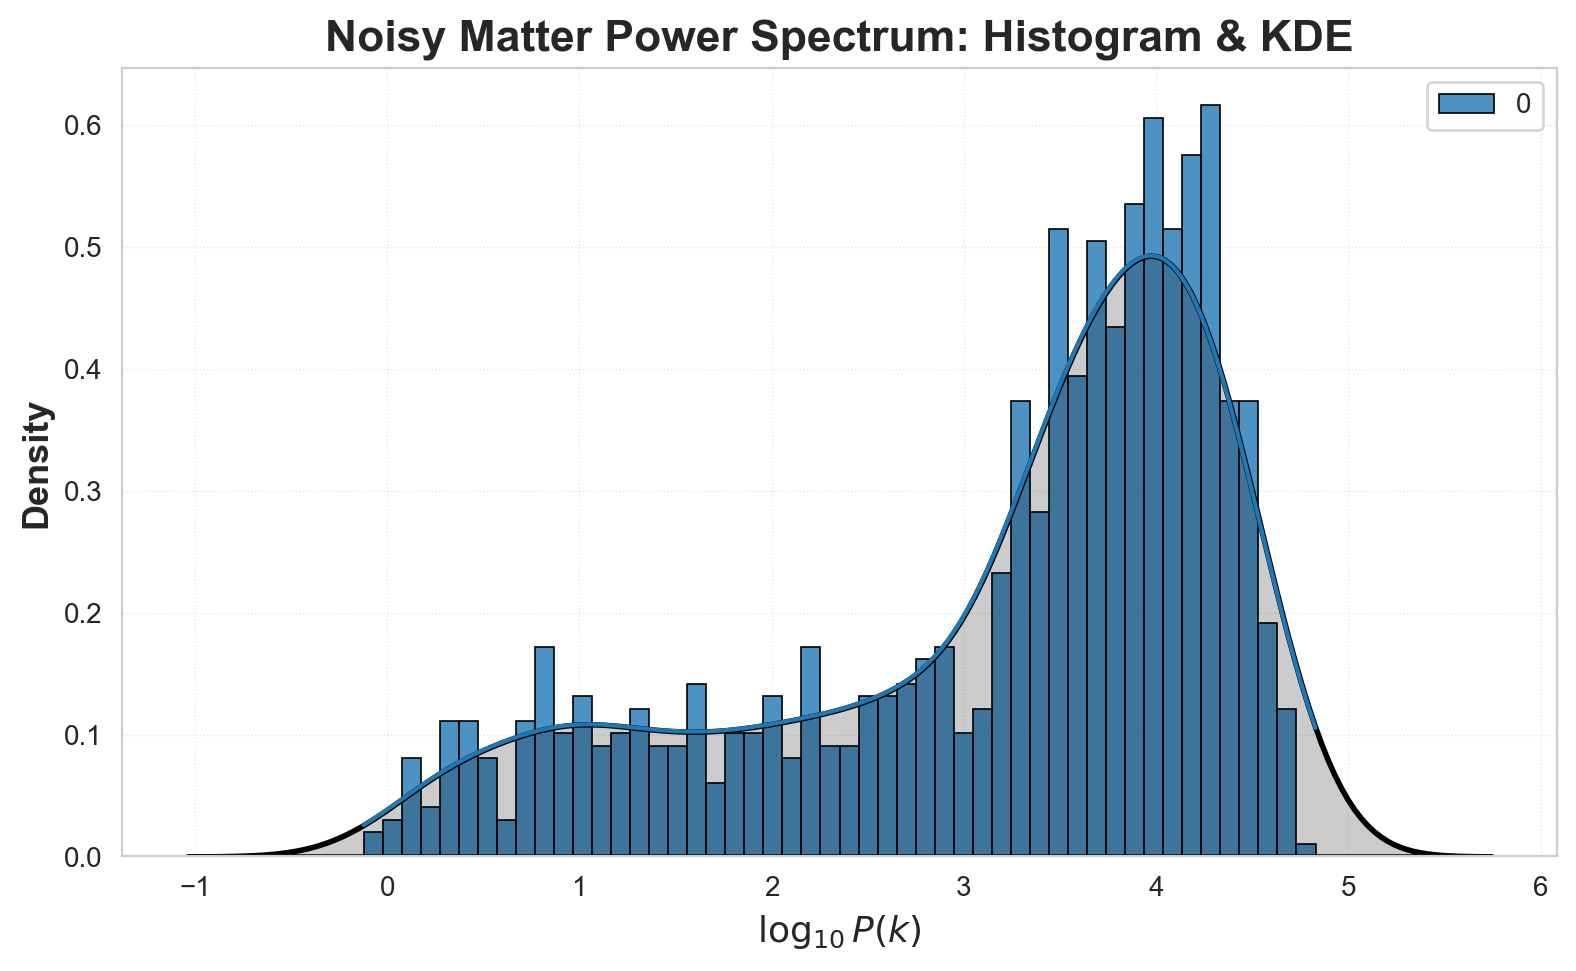

In [11]:

# Set global Seaborn theme
sns.set_style("whitegrid")

# Choose a visually distinct but elegant color
color = sns.color_palette("deep")[3]  # dark purple-blue

# Create the plot
plt.figure(figsize=(8, 5))

sns.histplot(
    pk_observations['log_P_k_noisy'],
    bins=50,
    kde= True,
    stat="density",
    color=color,
    edgecolor='black',
    linewidth=0.6,
    alpha=0.8
)

# KDE on top with fill
sns.kdeplot(
    pk_observations['log_P_k_noisy'].flatten(),
    color='black',
    linewidth=2,
    fill=True,
    alpha=0.2
)

# Titles and labels
plt.title('Noisy Matter Power Spectrum: Histogram & KDE', fontsize=16, weight='bold')
plt.xlabel(r'$\log_{10} P(k)$', fontsize=13, weight='semibold')
plt.ylabel('Density', fontsize=13, weight='semibold')

# Grid and layout
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()



# Bayes Flow

In [14]:
def prior(seed=None):
    rng = np.random.default_rng(seed)

    H0 = rng.uniform(20, 90)
    Omega_m = rng.uniform(0.2, 0.5)
    n_s = rng.uniform(0.7, 1.4)

    return {
        'H0': H0,
        'Omega_m': Omega_m,
        'n_s': n_s
    }


# Prior Plots

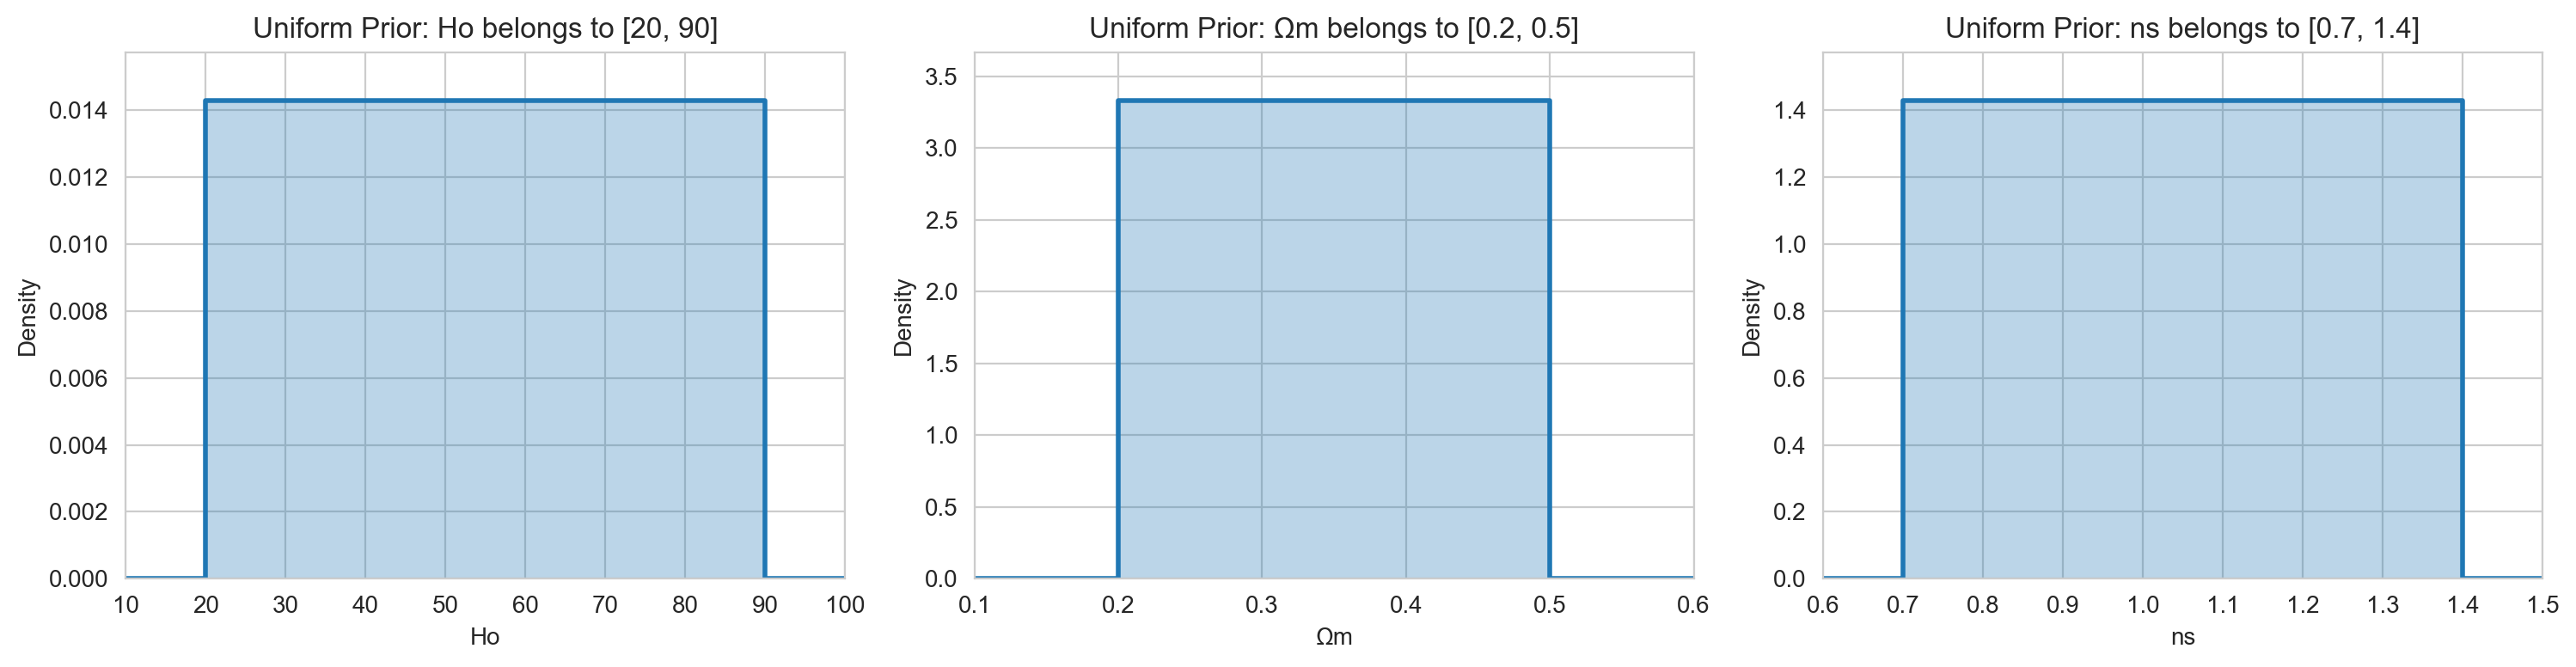

In [34]:
# Ensure Unicode symbols display correctly
plt.rcParams['axes.unicode_minus'] = False

# same ranges you gave
H0_range = (20, 90)
Om_range = (0.2, 0.5)
ns_range = (0.7, 1.4)

x_H0 = np.linspace(10, 100, 1000)
x_Om  = np.linspace(0.1, 0.6, 1000)
x_ns  = np.linspace(0.6, 1.5, 1000)

def plot_uniform_box(ax, x, a, b, title, xlabel):
    h = 1.0 / (b - a)
    # draw a perfect rectangle outline
    ax.plot([x.min(), a, a, b, b, x.max()],
            [0,        0, h, h, 0,      0], lw=2)
    # fill the plateau
    ax.fill_between([a, b], [h, h], [0, 0], alpha=0.3)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(0, h*1.1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Density')

plt.figure(figsize=(15, 4))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

plot_uniform_box(ax1, x_H0, *H0_range, 'Uniform Prior: Ho belongs to [20, 90]', 'Ho')
plot_uniform_box(ax2, x_Om, *Om_range, 'Uniform Prior: Ωm belongs to [0.2, 0.5]', 'Ωm')
plot_uniform_box(ax3, x_ns, *ns_range, 'Uniform Prior: ns belongs to [0.7, 1.4]', 'ns')

plt.tight_layout()
plt.show()


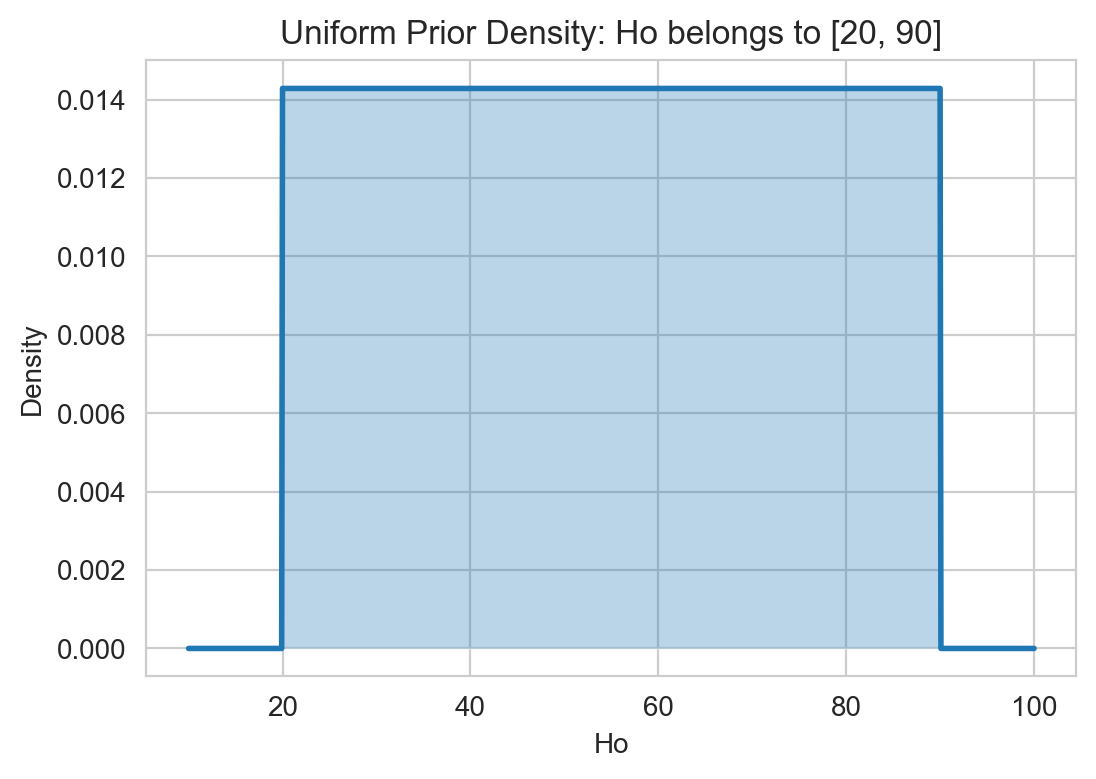

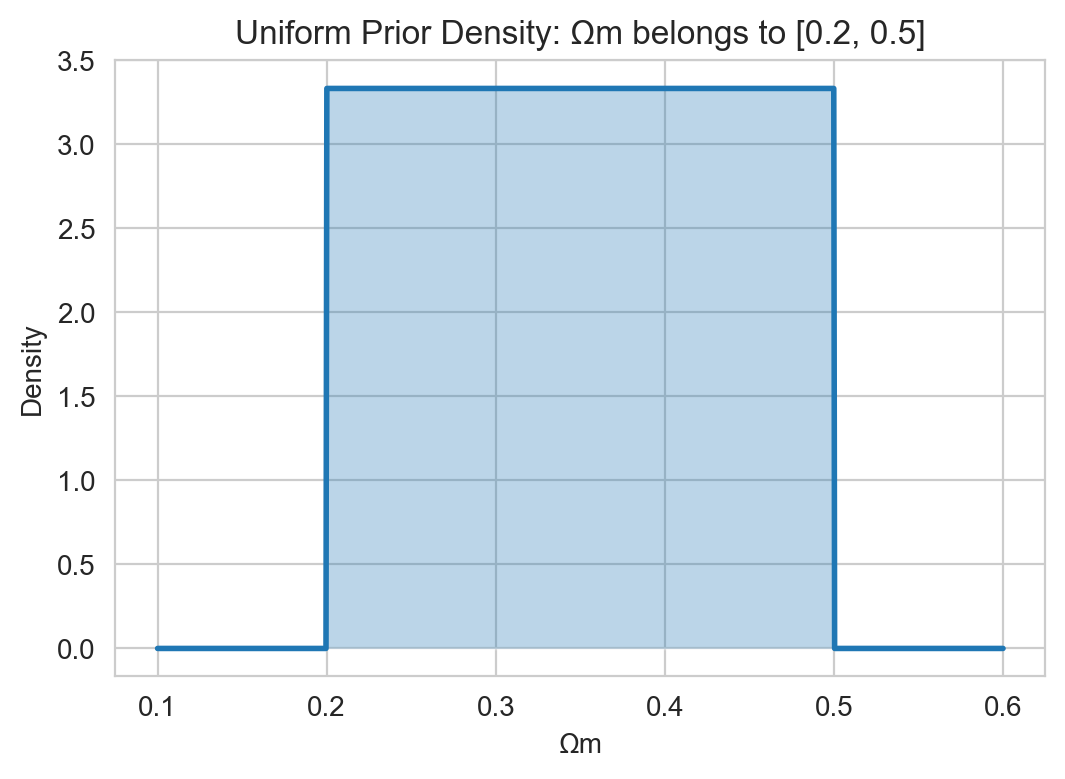

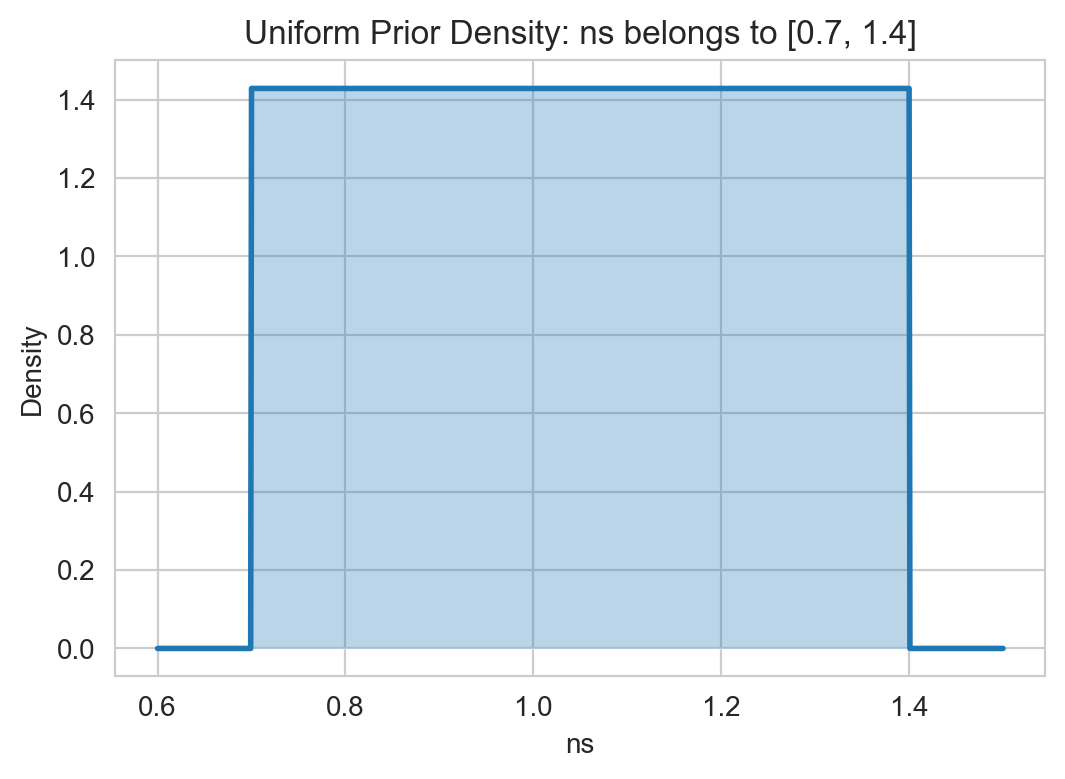

In [31]:
# Ensure Unicode symbols display correctly
plt.rcParams['axes.unicode_minus'] = False 

# Uniform density function
def uniform_density(x, a, b):
    return np.where((x >= a) & (x <= b), 1 / (b - a), 0)

# Plot 1: Hubble constant H0
x_H0 = np.linspace(10, 100, 1000)
y_H0 = uniform_density(x_H0, 20, 90)

plt.figure(figsize=(6, 4))
plt.plot(x_H0, y_H0, lw=2)
plt.fill_between(x_H0, 0, y_H0, alpha=0.3)
plt.title('Uniform Prior Density: Ho belongs to [20, 90]')
plt.xlabel('Ho')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot 2: Matter density Ωm
x_Om = np.linspace(0.1, 0.6, 1000)
y_Om = uniform_density(x_Om, 0.2, 0.5)

plt.figure(figsize=(6, 4))
plt.plot(x_Om, y_Om, lw=2)
plt.fill_between(x_Om, 0, y_Om, alpha=0.3)
plt.title('Uniform Prior Density: Ωm belongs to [0.2, 0.5]')
plt.xlabel('Ωm')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot 3: Spectral index ns
x_ns = np.linspace(0.6, 1.5, 1000)
y_ns = uniform_density(x_ns, 0.7, 1.4)

plt.figure(figsize=(6, 4))
plt.plot(x_ns, y_ns, lw=2)
plt.fill_between(x_ns, 0, y_ns, alpha=0.3)
plt.title('Uniform Prior Density: ns belongs to [0.7, 1.4]')
plt.xlabel('ns')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [ ]:
def likelihood(H0, Omega_m, n_s, k_vals=None, noise_level=0.2, seed=None, n = 256):
    """
    Generate log10 of the noisy matter power spectrum P(k) from given cosmological parameters.

    Parameters used:
        H0 (float): Hubble constant (km/s/Mpc)
        Omega_m (float): total matter density (Ω_m)
        n_s (float): spectral index
        k_vals (np.array or None): k values (1/Mpc). Default: logspace from 1e-3.3 to 10
        noise_level (float): standard deviation of additive Gaussian noise in log space
        seed (int or None): for reproducibility

    Returns:
        log_P_k_noisy (np.array): noisy log10 power spectrum at z = 0
    """

    if k_vals is None:
        k_vals = np.logspace(-3.3, 0.7, n)

    Omega_b = 0.05
    Omega_c = Omega_m - Omega_b
    h = H0 / 100
    ombh2 = Omega_b * h**2
    omch2 = Omega_c * h**2

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(ns=n_s)
    pars.set_matter_power(redshifts=[0], kmax=max(k_vals))

    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, kmax=max(k_vals))
    P_k = PK.P(0, k_vals)

    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    log_k = np.log10(k_vals)
    log_Pk_clean = np.log10(P_k)
    log_noise = rng.normal(0, noise_level, len(P_k))
    log_P_k_noisy = log_Pk_clean + log_noise


    # shape adjustments
    log_k = log_k.reshape(-1, 1)
    log_Pk_clean = log_Pk_clean.reshape(-1, 1)
    log_P_k_noisy = log_P_k_noisy.reshape(-1, 1)

    return {
        'log_P_k_noisy': log_P_k_noisy
    }

# Testing Prior and Likelihood

In [12]:
parameters_testing = prior()
print(parameters_testing)

{'H0': 56.77621537254461, 'Omega_m': 0.3418271082296259, 'n_s': 1.0860007345709546}


In [13]:
# Generate the noisy power spectrum using parameters
log_Pk_testing = likelihood(
    H0=parameters_testing['H0'],
    Omega_m=parameters_testing['Omega_m'],
    n_s=parameters_testing['n_s'],
    noise_level=0.2,   # 20% relative Gaussian noise
    n = 512
)

In [14]:
log_Pk_testing.keys()

dict_keys(['log_P_k_noisy'])

In [15]:
log_Pk_testing['log_P_k_noisy'].shape

(512, 1)

<>:24: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\l'
C:\Users\sabar\AppData\Local\Temp\ipykernel_29792\1579819407.py:24: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Histogram and KDE of Noisy $\log_{10} P(k)$ Values', fontsize=16, weight='bold')


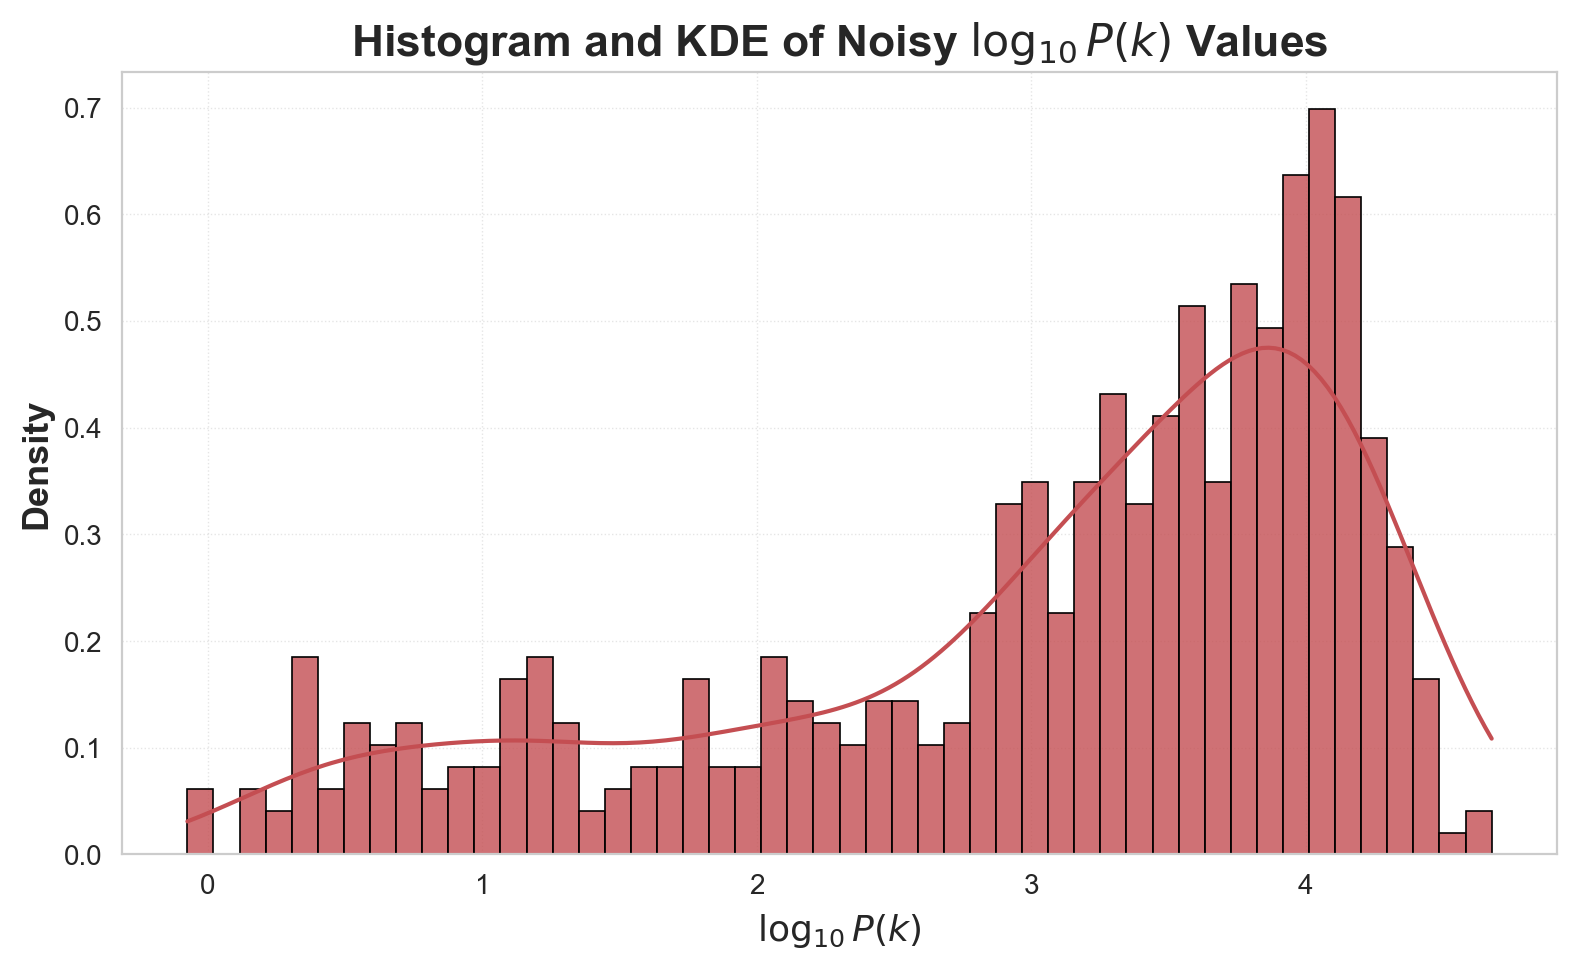

In [16]:

# Set global Seaborn theme
sns.set_style("whitegrid")

# Choose a visually distinct but elegant color (dark purple-blue from Seaborn "deep" palette)
color = sns.color_palette("deep")[3]

# Create the plot
plt.figure(figsize=(8, 5))

sns.histplot(
    log_Pk_testing['log_P_k_noisy'].flatten(),
    bins=50,
    kde=True,
    stat="density",
    color=color,
    edgecolor='black',
    linewidth=0.6,
    alpha=0.8
)



# Titles and labels
plt.title('Histogram and KDE of Noisy $\log_{10} P(k)$ Values', fontsize=16, weight='bold')
plt.xlabel(r'$\log_{10} P(k)$', fontsize=13, weight='semibold')
plt.ylabel('Density', fontsize=13, weight='semibold')

# Grid and layout
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


# --------------------------  Bayes Flow  --------------------------------------

### Sample from the Joint Distribution $(\theta^{(s)}, y^{(s)}) \sim P(\theta, y)$

### Simulator

In [17]:
simulator = bf.make_simulator([prior, likelihood])

###  Adapter 

In [18]:
adapter = (
    bf.Adapter()
    .concatenate(["H0", "Omega_m", "n_s"], into="inference_variables")
    .rename("log_P_k_noisy", "summary_variables")
)

In [69]:
adapter_std = (
    bf.Adapter()
    .concatenate(["H0", "Omega_m", "n_s"], into="inference_variables")
    .rename("log_P_k_noisy", "summary_variables")
    .standardize("summary_variables")
)

### Summary Networks

In [20]:
# 1) Deep
summary_network_Deep = bf.networks.DeepSet()

In [ ]:
# 2) Set Trans
summary_network_Set_Trans = bf.networks.SetTransformer()

In [22]:
# 3) TS
summary_network_TS = bf.networks.TimeSeriesTransformer()

Summary network for RNN

In [24]:
import tensorflow as tf

class RNNSummaryNet(tf.keras.Model):
    def __init__(self,
                 latent_dim=64,
                 rnn_units=128,
                 bidirectional=True,
                 cell='gru',                  # 'gru' or 'lstm'
                 dropout=0.1,
                 recurrent_dropout=0.0,
                 use_masking=True,            # set False if you never pad sequences
                 pool='avg'                   # 'avg', 'max', or 'last'
                ):
        super().__init__()
        self.latent_dim = latent_dim
        self.use_masking = use_masking
        self.pool_mode = pool

        if self.use_masking:
            self.mask = tf.keras.layers.Masking()

        RNNCell = tf.keras.layers.GRU if cell.lower() == 'gru' else tf.keras.layers.LSTM

        # Return full sequences so we can pool robustly (works well with masking)
        base_rnn = RNNCell(rnn_units, return_sequences=True, recurrent_dropout=recurrent_dropout)
        self.rnn = tf.keras.layers.Bidirectional(base_rnn) if bidirectional else base_rnn

        # Pooling to get fixed-size vector
        self.global_avg = tf.keras.layers.GlobalAveragePooling1D()
        self.global_max = tf.keras.layers.GlobalMaxPooling1D()

        self.norm = tf.keras.layers.LayerNormalization()
        self.drop = tf.keras.layers.Dropout(dropout)
        self.dense = tf.keras.layers.Dense(latent_dim, activation='relu')

    def build(self, input_shape):
        # Match your CNN's dynamic build pattern (important for BayesFlow)
        dummy_input = tf.zeros(input_shape)
        _ = self.call(dummy_input, training=False)
        super().build(input_shape)

    def _maybe_expand_channel(self, x):
        # Accept (batch, T) or (batch, T, C)
        if x.shape.rank == 2:
            x = tf.expand_dims(x, -1)
        return x

    def call(self, x, training=False):
        x = self._maybe_expand_channel(x)
        if self.use_masking:
            x = self.mask(x)

        x = self.rnn(x, training=training)  # (batch, T, H or 2H)

        if self.pool_mode == 'max':
            x = self.global_max(x)
        elif self.pool_mode == 'last':
            # Take last timestep robustly (handles dynamic T)
            x = x[:, -1, :]
        else:
            # default avg
            x = self.global_avg(x)

        x = self.norm(x)
        x = self.drop(x, training=training)
        return self.dense(x)

    def compute_metrics(self, summary_variables, stage=None):
        outputs = self(summary_variables)
        return {"outputs": outputs}

    def compute_output_shape(self, input_shape):
        # Ensure input_shape is a tuple like (batch_size, sequence_length, channels)
        batch_size = input_shape[0] if isinstance(input_shape, tuple) else None
        return (batch_size, self.latent_dim)

# 4) RNN 
# Keep latent_dim=32 to match your current setup
summary_network_RNN = RNNSummaryNet(
    latent_dim=32,
    rnn_units=128,
    bidirectional=True,
    cell='gru',          # switch to 'lstm' if you prefer
    dropout=0.1,
    recurrent_dropout=0.0,
    use_masking=True,
    pool='avg'           # try 'max' or 'last' if needed
)


# (A) Affine - Coupling Inference Networks

In [25]:
# affine coupling
inference_network_affine = bf.networks.CouplingFlow()

### 1) Affine + RNN

In [ ]:
# RNN we have to change to deep to RNN variable name

workflow_affine_Deep = bf.BasicWorkflow(
     inference_network=inference_network_affine,
     summary_network=summary_network_RNN,
     adapter=adapter_std,
     simulator=simulator
)

### Simulating Datasets for 
1) Training
2) Validation
3) Test

# Timing training data sampling

In [31]:
# Timing training data sampling
start_time = time.time()
training_data = workflow_affine_Deep.simulate(6000)
training_duration = time.time() - start_time
print(f"Training data simulation took {training_duration:.2f} seconds.")

with open("training_data.pkl", "wb") as f:
    pickle.dump(training_data, f)

Training data simulation took 4424.47 seconds.


In [42]:
with open("training_data.pkl", "rb") as f:
    training_data = pickle.load(f)

    print(training_data.keys())  # Should match original keys

dict_keys(['H0', 'Omega_m', 'n_s', 'log_P_k_noisy'])


# Timing validation data sampling


# Save validation data
with open("validation_data.pkl", "wb") as f:
    pickle.dump(validation_data, f)

In [46]:
# Timing validation data sampling
start_time = time.time()
validation_data = workflow_affine_Deep.simulate(1000)
validation_duration = time.time() - start_time
print(f"Validation data simulation took {validation_duration:.2f} seconds.")

# Save validation data
with open("validation_data.pkl", "wb") as f:
    pickle.dump(validation_data, f)

Validation data simulation took 717.00 seconds.


In [47]:
# Load validation data
with open("validation_data.pkl", "rb") as f:
    validation_data = pickle.load(f)

print(validation_data.keys())

dict_keys(['H0', 'Omega_m', 'n_s', 'log_P_k_noisy'])


# Timing test data sampling


In [49]:
# Timing test data sampling
start_time = time.time()
test_data = workflow_affine_Deep.simulate(1000)
test_duration = time.time() - start_time
print(f"Test data simulation took {test_duration:.2f} seconds.")

# Save test data
with open("test_data.pkl", "wb") as f:
    pickle.dump(test_data, f)

Test data simulation took 720.94 seconds.


In [50]:
# Load test data
with open("test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

print(test_data.keys())

dict_keys(['H0', 'Omega_m', 'n_s', 'log_P_k_noisy'])


In [62]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

history_affine_Deep = workflow_affine_Deep.fit_offline(
    data=training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data=validation_data,
    standardize=["inference_variables", "summary_variables"],
    callbacks=[early_stop]
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
c:\Users\sabar\OneDrive\Documents\GitHub\Estimating-Cosmological-Parameters-from-Galaxy-Power-Spectrum\.venv\Lib\site-packages\bayesflow\adapters\transforms\standardize.py:74: FutureWarning: Dynamic standardization is deprecated and will be removed in later versions.Instead, use the standardize argument of the approximator / workflow instance or provide fixed mean and std arguments. You may incur some redundant computations if you keep this transform.
  warnings.warn(


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 686ms/step - loss: 4.0449 - val_loss: 3.3710
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 616ms/step - loss: 2.7636 - val_loss: 2.2129
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 633ms/step - loss: 2.2601 - val_loss: 2.0278
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 648ms/step - loss: 1.8021 - val_loss: 1.4541
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 754ms/step - loss: 1.5145 - val_loss: 0.3856
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 663ms/step - loss: 0.4120 - val_loss: 0.3040
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 645ms/step - loss: 0.2848 - val_loss: 0.3450
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 637ms/step - loss: 0.2816 - val_loss: 0.3030
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 626ms/step - loss: 0.1745 - val_loss: 0.0047
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 637ms/step - loss: 0.0837 - val_loss: -0.0121
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 665ms/step - loss: 0.0532 - val_loss: 0.0714
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3

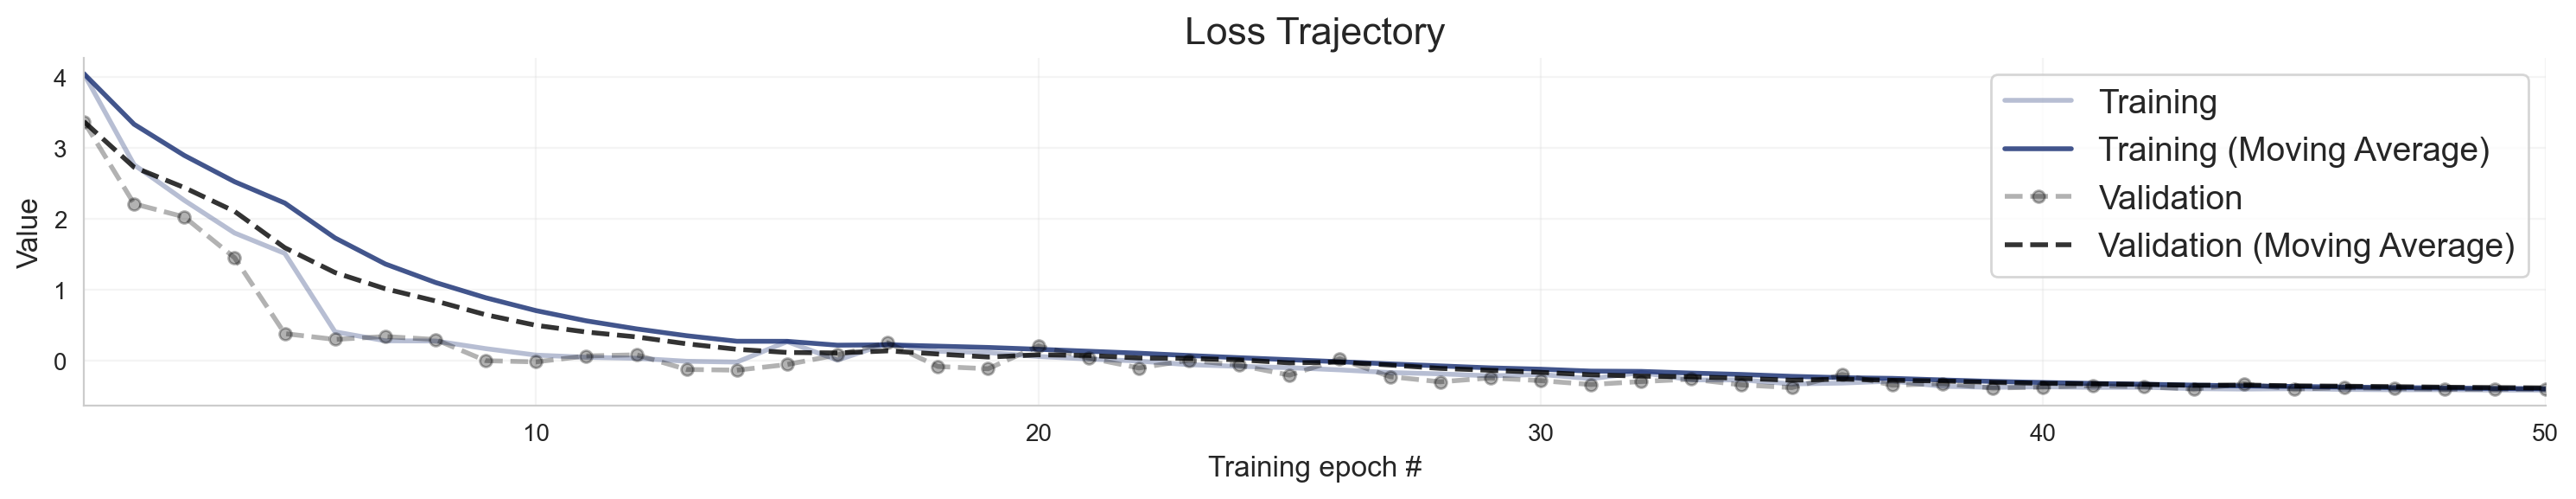

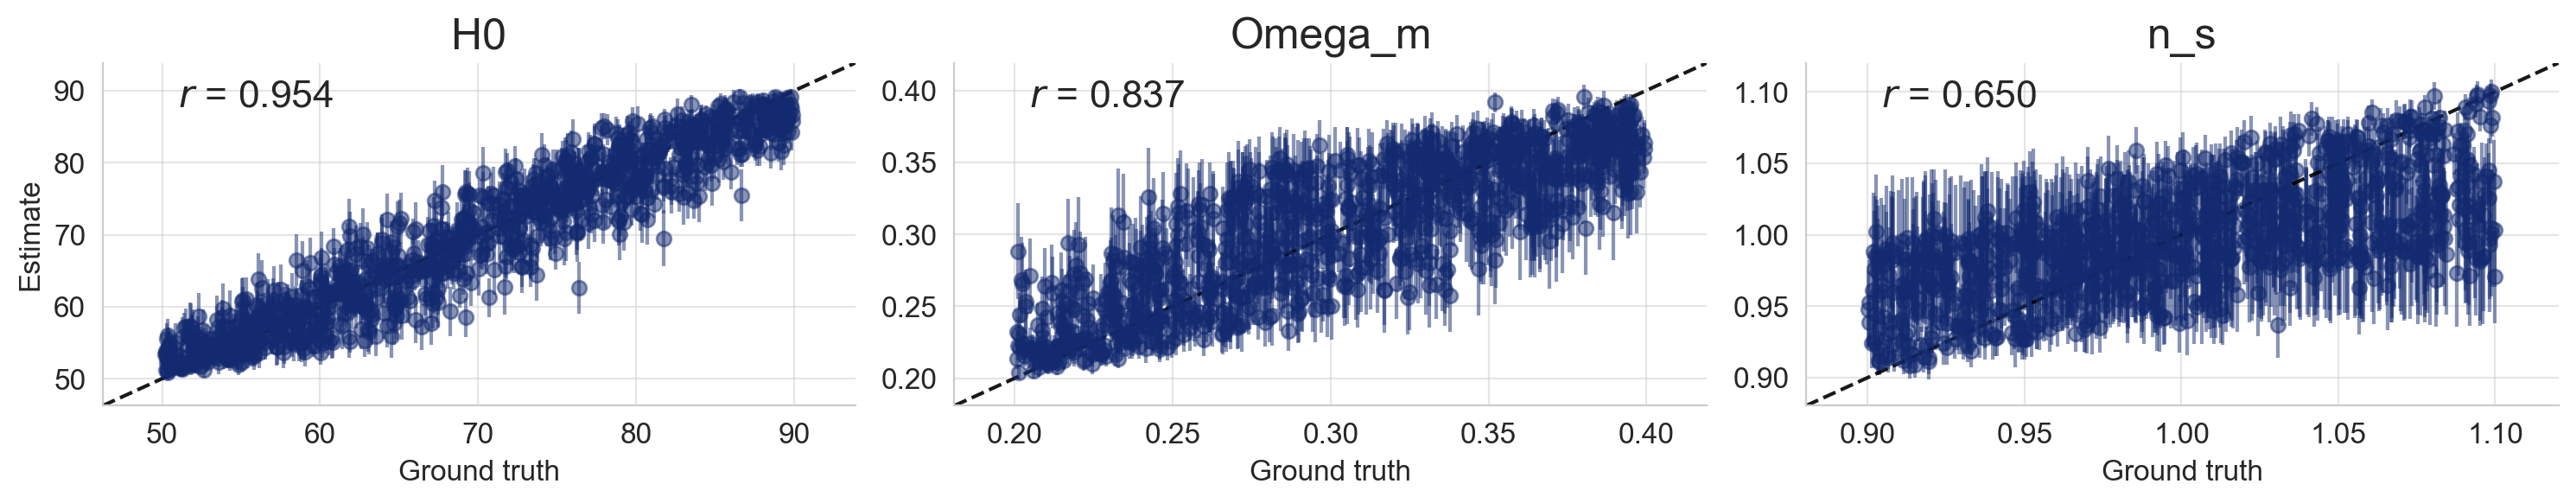

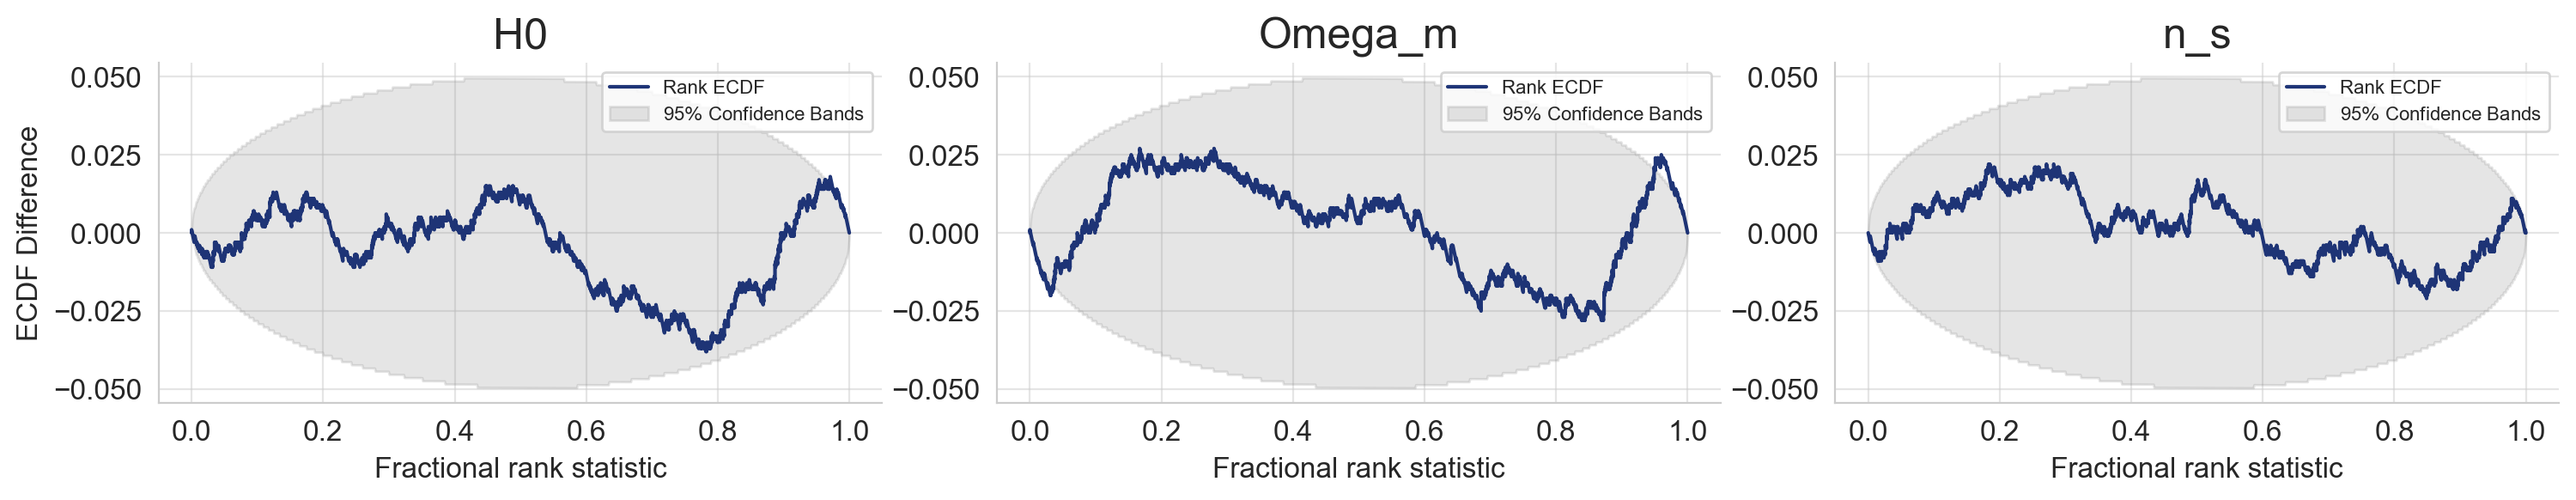

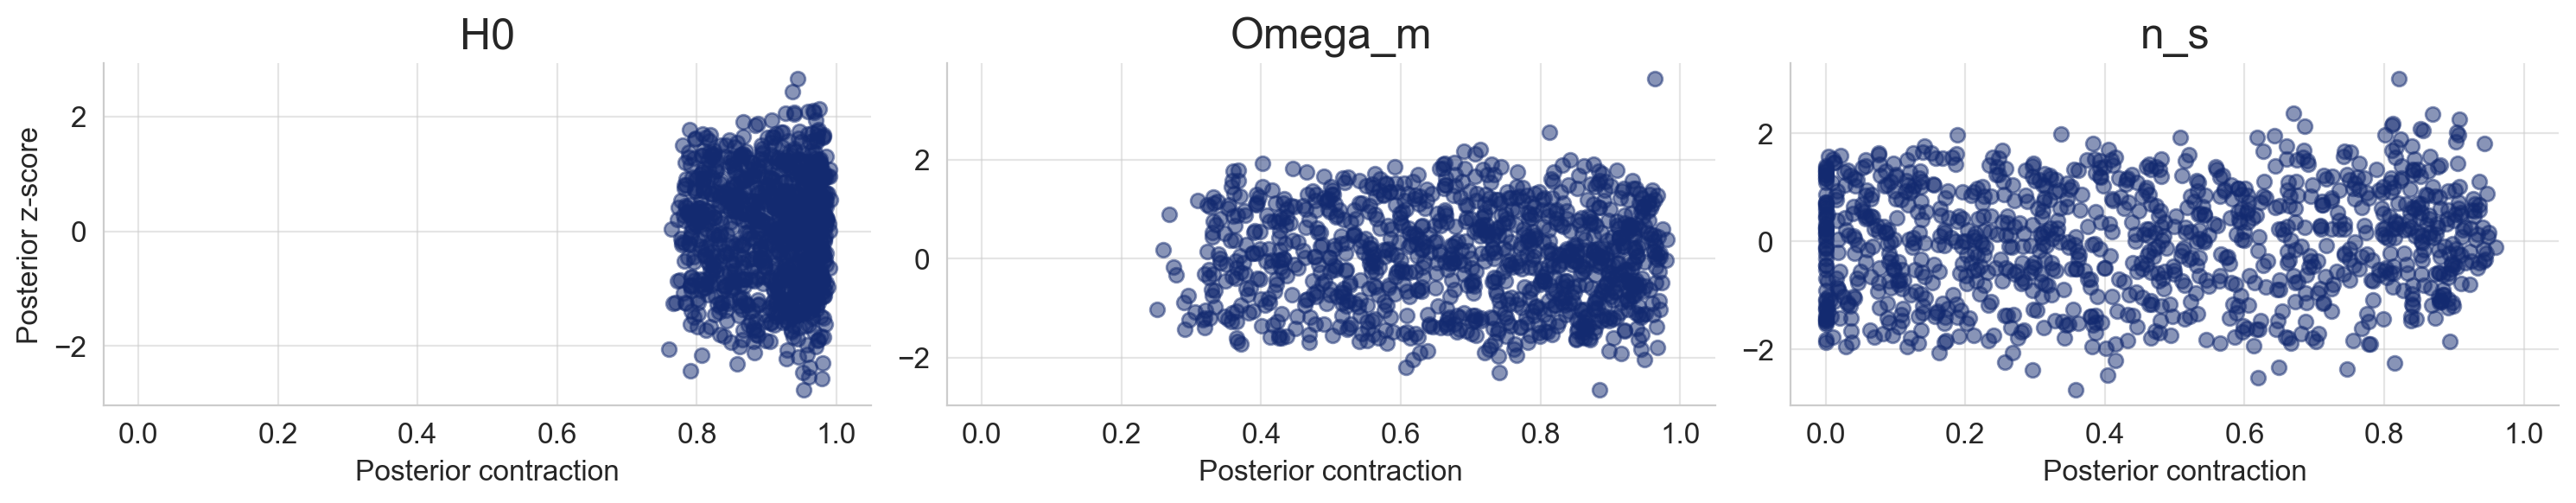

In [63]:
figures_affine_Deep = workflow_affine_Deep.plot_default_diagnostics(
    test_data=test_data,
    calibration_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)

# (B) Spline - Coupling Inference Networks

In [ ]:
# spline coupling 
spline_inference = bf.networks.CouplingFlow(transform="spline")

### 4) Spline + RNN

In [ ]:
# More expressive Affine Coupling Flow
spline_inference = bf.networks.CouplingFlow(
    num_coupling_layers=12,             # Go deeper (more transformations)
    coupling_design="spline",           # Stick to spline (more flexible than affine)
    transform_net_units=[128, 128, 128],     # Larger subnetworks for richer conditioning
    transform_net_activation="relu",
    dropout=0.00,
    latent_size=3
)

In [ ]:
workflow_spline_RNN = bf.BasicWorkflow(
     inference_network=spline_inference,
     summary_network=summary_network_RNN,
     adapter=adapter_std,
     simulator=simulator
)

In [84]:
# Define EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=50,           # Stop if no improvement after 20 epochs
    restore_best_weights=True # Roll back to the best weights
)

In [86]:
history_spline_RNN = workflow_spline_RNN.fit_offline(
    data = training_data,
    epochs=1000,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop],
    standardize=["inference_variables", "summary_variables"]
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.


Epoch 1/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 810ms/step - loss: 0.0022 - val_loss: 0.1049
Epoch 2/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 778ms/step - loss: -0.0088 - val_loss: -0.0355
Epoch 3/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 39s 840ms/step - loss: 0.0288 - val_loss: -0.1541
Epoch 4/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 791ms/step - loss: 7.0646e-04 - val_loss: 0.2055
Epoch 5/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 811ms/step - loss: 0.0147 - val_loss: -0.0701
Epoch 6/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 800ms/step - loss: 0.0139 - val_loss: -0.1954
Epoch 7/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 803ms/step - loss: 0.0289 - val_loss: -0.0028
Epoch 8/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 39s 829ms/step - loss: 0.0361 - val_loss: -0.0055
Epoch 9/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 39s 824ms/step - loss: 0.0482 - val_loss: -0.1175
Epoch 10/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 884ms/step - loss: 0.0354 - val_loss: 0.2786
Epoch 11/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 893ms/step - loss: 0.0447 - val_loss: -0.0446
Epoch 

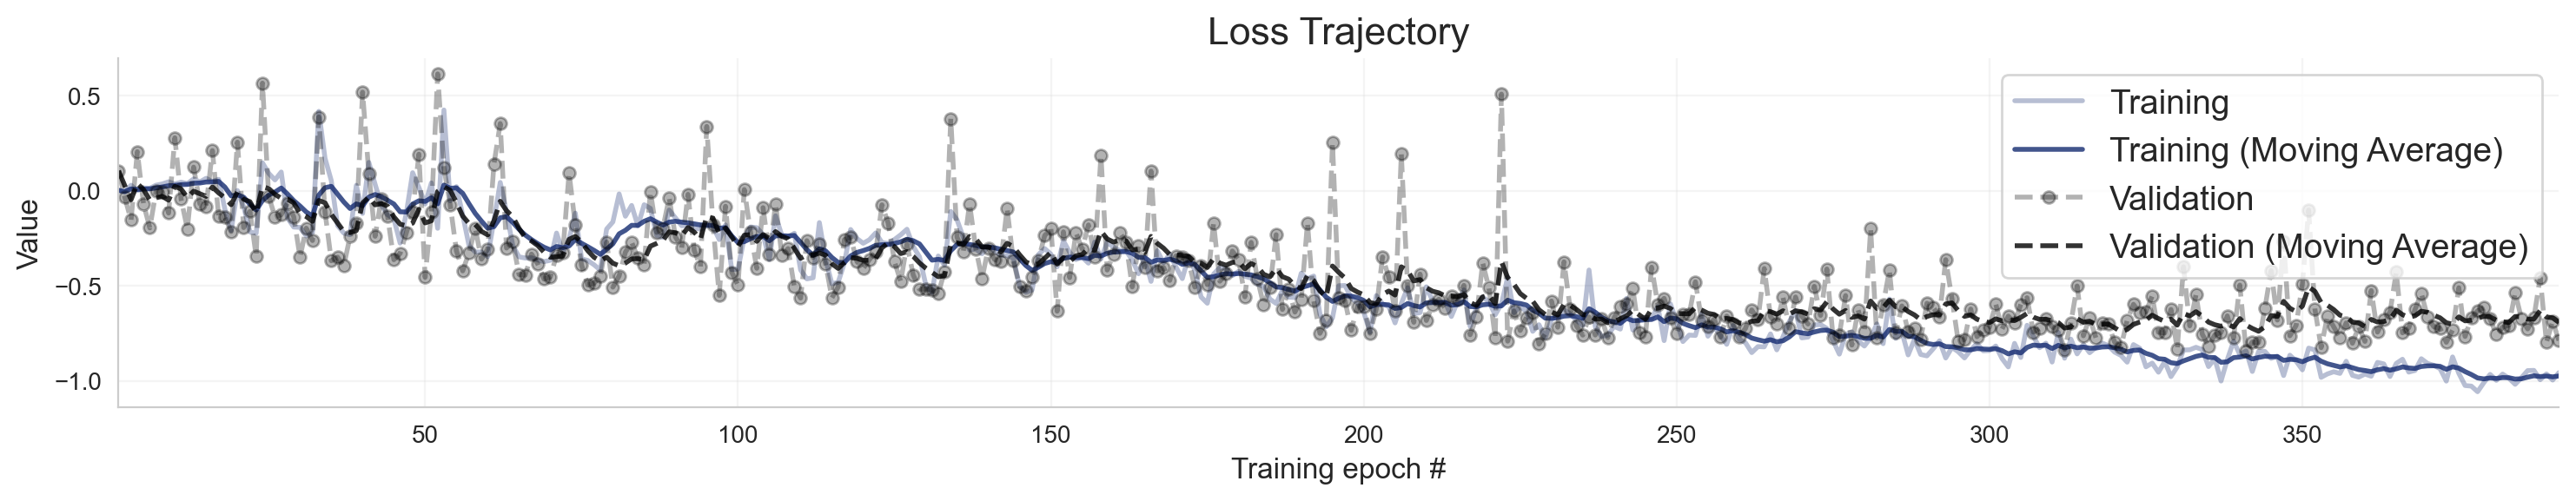

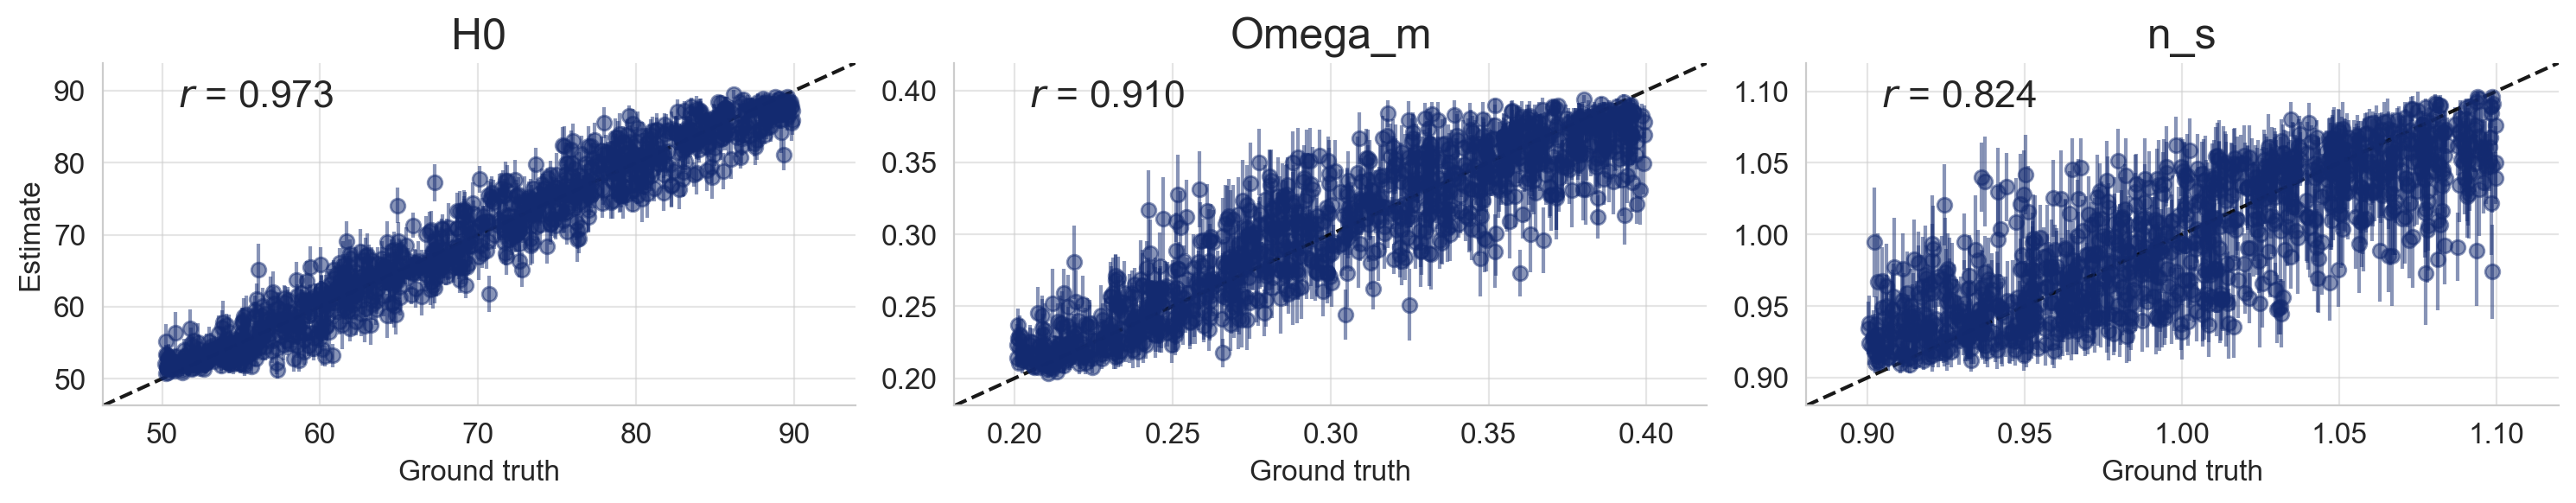

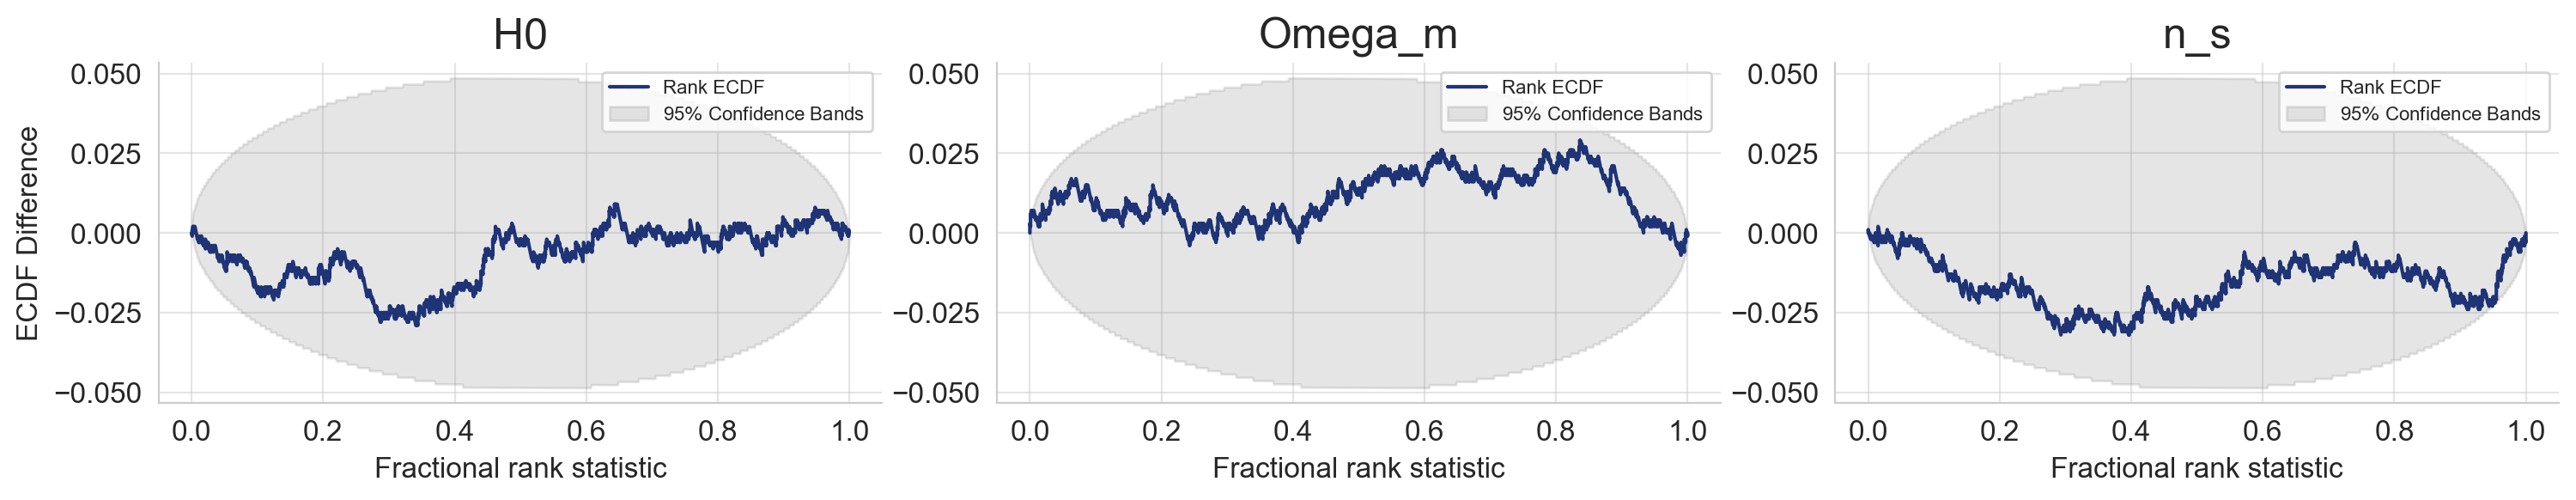

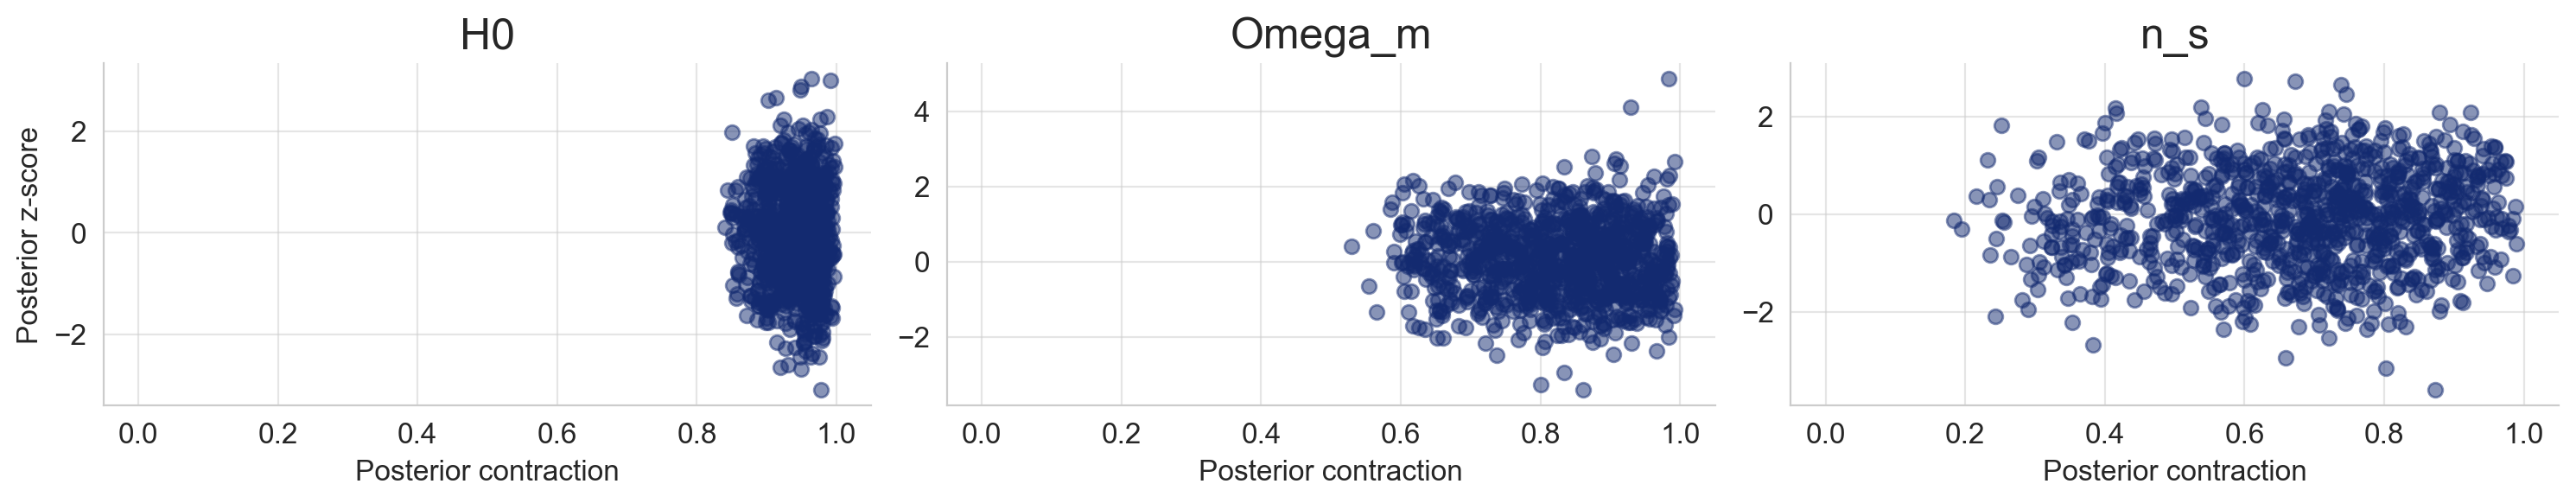

In [89]:
figures_spline_RNN = workflow_spline_RNN.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)

# (C) Flow Matching - Inference Networks

In [ ]:
inference_network_flow = bf.networks.FlowMatching()

### 4) Flow + CNN

In [91]:
workflow_flow_RNN = bf.BasicWorkflow(
     inference_network=inference_network_flow,
     summary_network=summary_network_RNN,
     adapter=adapter_std,
     simulator=simulator
)

In [96]:
history_flow_RNN = workflow_flow_RNN.fit_offline(
    data=training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 779ms/step - loss: 1.1666 - val_loss: 0.8501
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 39s 836ms/step - loss: 0.8911 - val_loss: 0.6483
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 39s 841ms/step - loss: 0.8460 - val_loss: 0.6537
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 967ms/step - loss: 0.7660 - val_loss: 0.6759
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 44s 931ms/step - loss: 0.7193 - val_loss: 0.7013
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 977ms/step - loss: 0.7187 - val_loss: 0.5956
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 988ms/step - loss: 0.7053 - val_loss: 0.6444
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 0.6814 - val_loss: 0.6247
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: 0.6891 - val_loss: 0.6603
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: 0.6708 - val_loss: 0.5306
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 0.6735 - val_loss: 0.5975
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - 

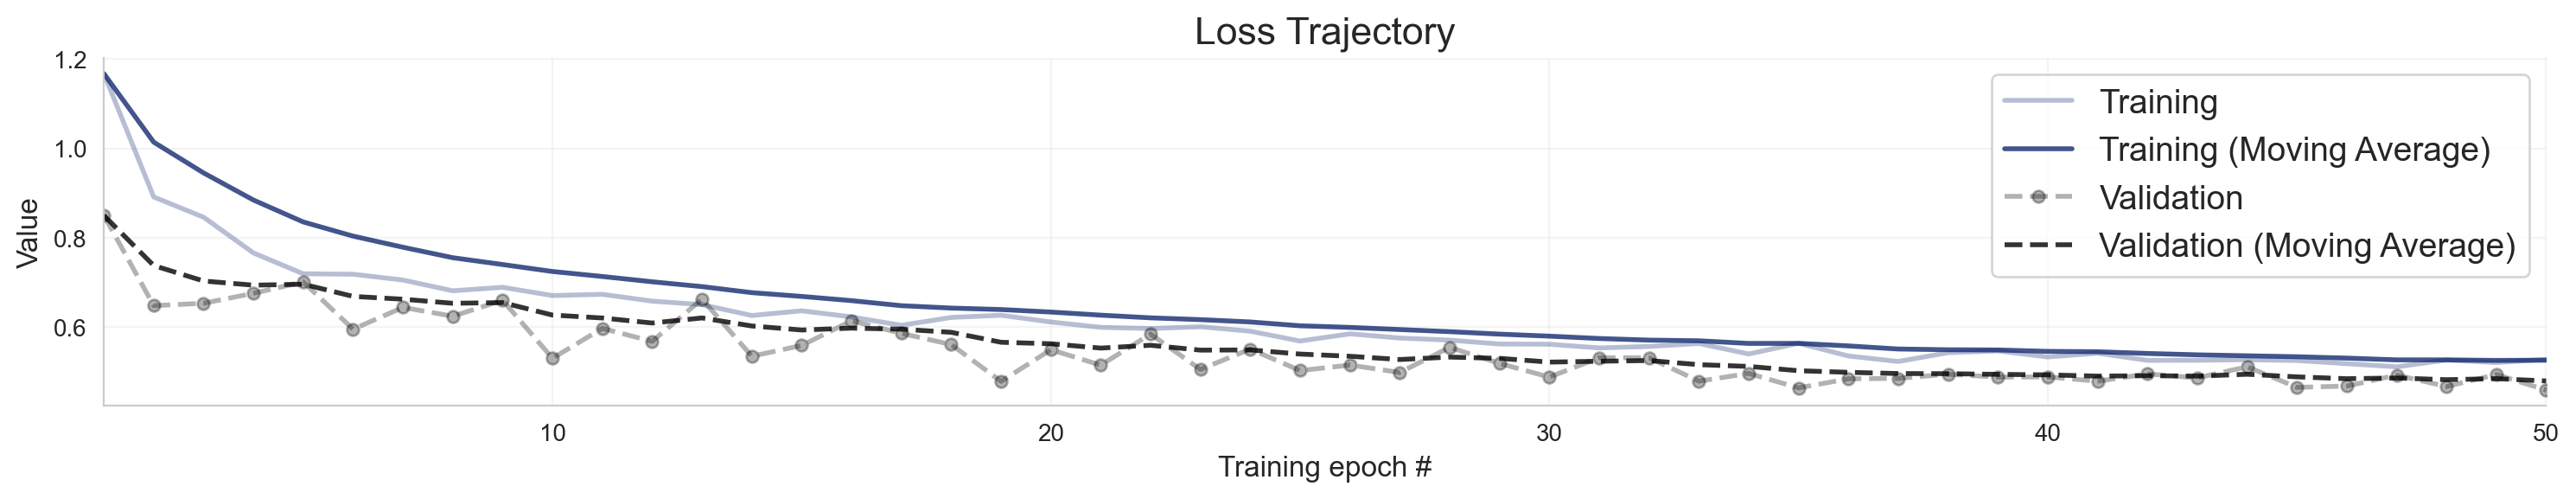

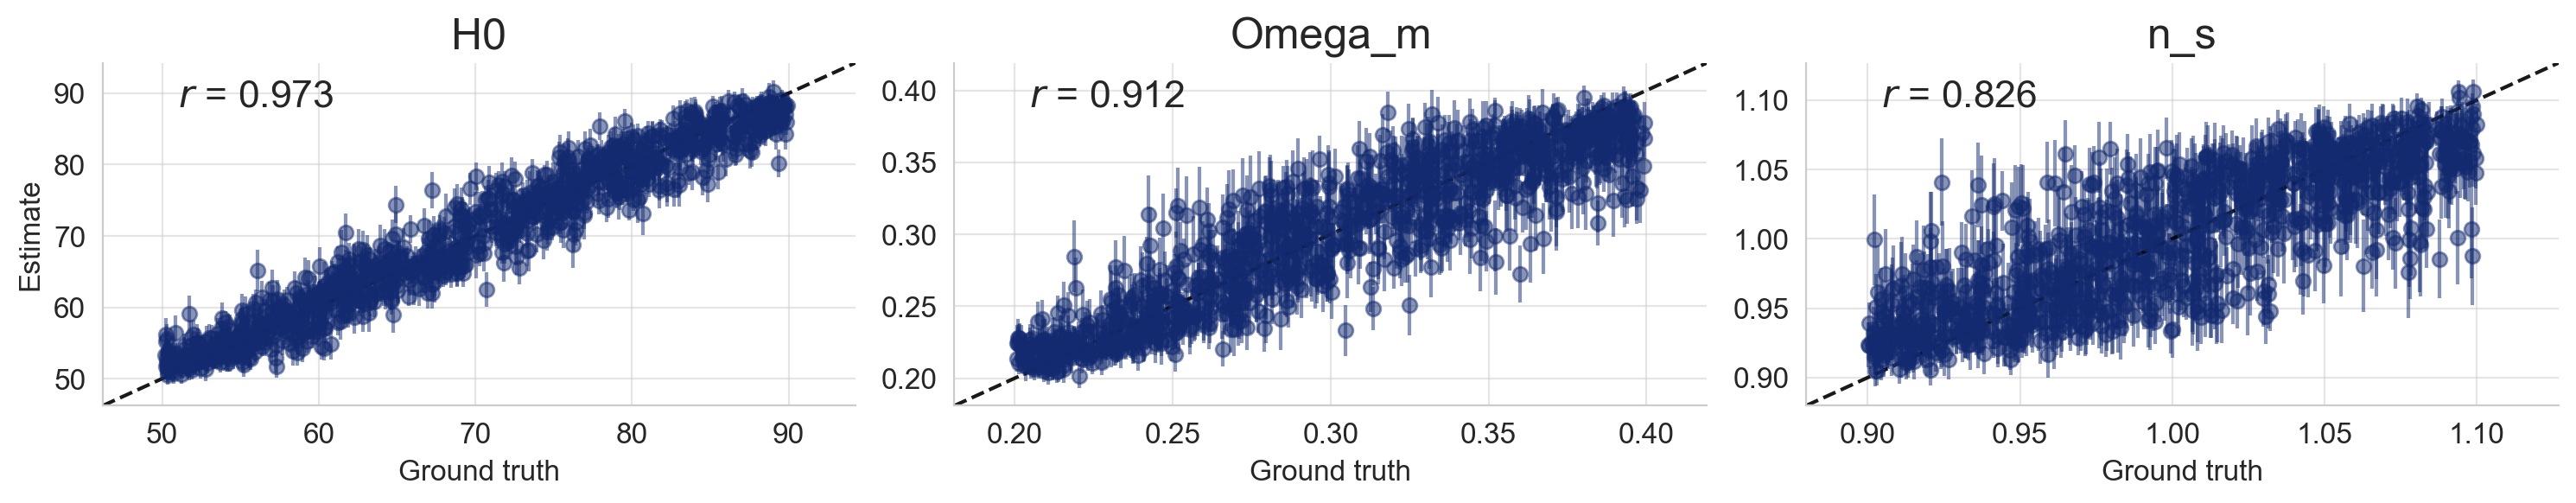

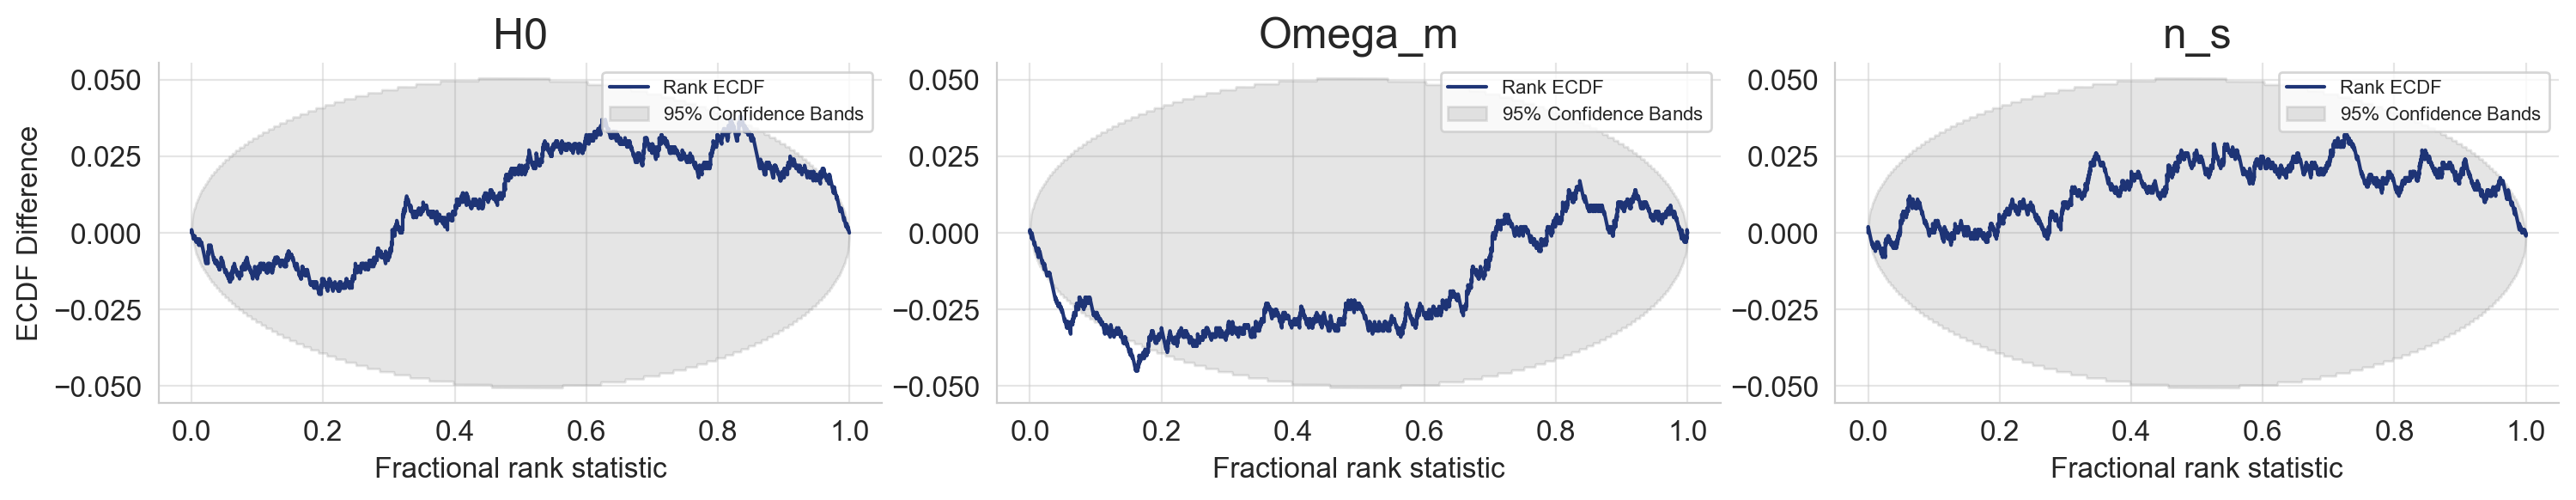

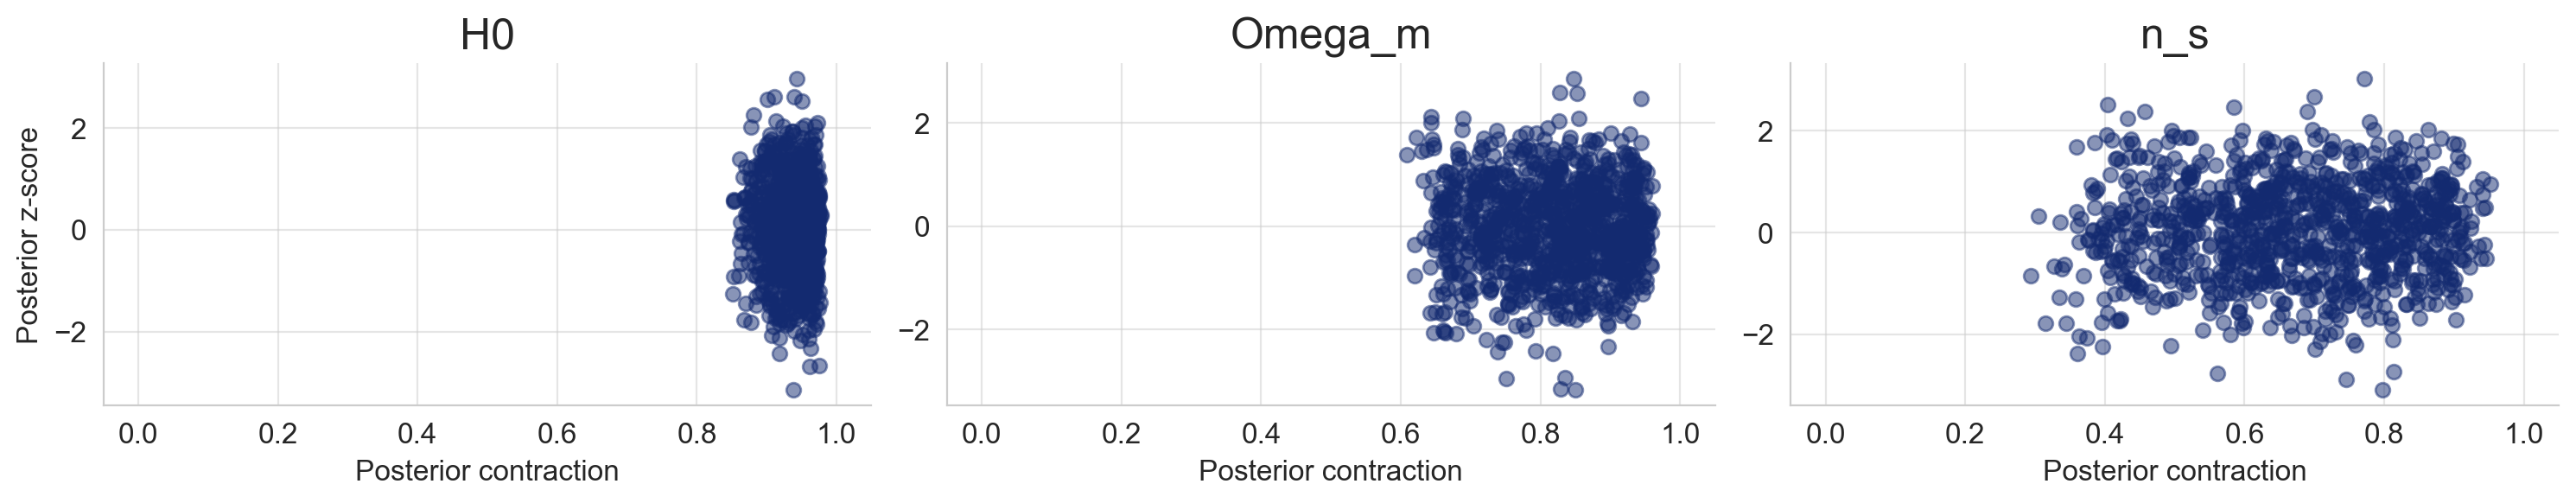

In [97]:
figures_flow_RNN = workflow_flow_RNN.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)